In [1]:
from torchvision import datasets, transforms
from sklearn.model_selection import train_test_split
from base import BaseDataLoader
import pandas as pd
import gzip
import numpy as np
import re
import pickle
import visdom
import random
from gensim.parsing.preprocessing import remove_stopwords

In [2]:
import torch
from torch import nn
import torch.nn.functional as F
from torch.nn.utils.rnn import pack_padded_sequence
from torch.autograd import Variable

In [4]:
from skorch import NeuralNetClassifier
import torch.optim as optim

In [5]:
import matplotlib.pyplot as plt

In [6]:
class AmznDataLoader():
        def __init__(self):
            df = self.getDF('./data/reviews_Amazon_Instant_Video_5.json.gz')
    #         display(self.df)
    #         print(self.df.loc[0][['overall','reviewText']])
            df = df[['reviewText', 'overall']]
            df['reviewText'] = df['reviewText'].apply(lambda x : self.title_parsing(x))
            X = df['reviewText']
            y = df['overall']
            self.weight_matrix = self.get_weigth_matrix(X)
            X = self.indicesMatrix(X)
            self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(X, y, test_size=0.2, random_state=42)
            
            
        def title_parsing(self, title):  
            # remove stop words and tokenization 
            title = re.sub('[^a-zA-Z]', ' ', str(title))
            title = title.lower()
            title = remove_stopwords(title)  ## remove stop words, corpus size 52680            
            title = title.split()
            title = [word for word in title if len(word) >1 ]
            return title
        
        
        def parse(self, path):
            g = gzip.open(path, 'rb')
            for l in g:
                yield eval(l)
            
        def getDF(self, path):
            i = 0
            df = {}
            for d in self.parse(path):
                df[i] = d
                i += 1
            return pd.DataFrame.from_dict(df, orient='index')        

        def buildCorpus(self, X):
            '''
            return a dictionary with 'word' and its index in corpus as key and value respectively
            '''
            word2idx = {}
            idx2word = [] ## alternatively use if.. condition
            idx = 0 
            for row in X:
                for word in row:
                    if word not in word2idx:
                        idx2word.append(word)                
                        word2idx[word] = len(idx2word) - 1
#             pickle.dump(word2idx, open('./data/corpusDict.txt', 'wb'))
            return word2idx   
        
    
        def indicesMatrix(self, X):
            '''
            return matrix (num_reviews, maxNumberWords) such that review text transformed to index
            '''
            word2idx = self.buildCorpus(X)
#             word2idx = pickle.load(open('./data/corpusDict.txt', 'rb'))
            ## 53008 words in corpus
    
            corpusSize = len(word2idx) 
        
            ###
            k = sorted(len(x) for x in X)
            plt.hist(k)
            ###
            
#             maxNumberWords = sorted(len(x) for x in X)[-1]
#             print ("maximum", maxNumberWords)
            maxNumberWords =40

            index_matrix = np.zeros((X.shape[0], maxNumberWords))          
            for i, row in enumerate(X):
                for j, word in enumerate(row):
#                     try:
#                         index_matrix[i,j] = word2idx[word]
#                         words_found += 1
#                     except KeyError:
#                         index_matrix[i,j] = corpusSize     

                    index_matrix[i,j] = word2idx[word]
                    if j >= maxNumberWords-1 : 
                        break
            if maxNumberWords % 2 == 1:
                x0 = np.full((index_matrix.shape[0], 1), maxNumberWords)
                index_matrix = np.hstack((index_matrix, x0))
            return index_matrix
        
        def get_weigth_matrix(self, X): #max norm for linear layer
            '''
            return matrix contains embedding for word in corpus/review text
            Note that the word cannot be found in the glove returns ?? as embedding
            '''

            glove = {}

            with open(f'./data/glove.6B.50d.txt', 'rb') as f:
                for l in f:
                    line = l.decode().split()           
                    word = line[0]
        #            words.append(word)
        #             word2idx[word] = idx
        #            idx += 1
                    vect = np.array(line[1:]).astype(np.float)
        #             vectors.append(vect)
        #     vectors = np.reshape(vectors, (400000, 50))
                    glove.update({word:vect})
        #     glove = {word2idx[w]: vectors[word2idx[w]] for w in words}  # alternatively generate weights_matrix directly

            target_vocab = self.buildCorpus(X)
            #except
            #exceptKey = list(set(list(glove.keys())).difference(list(target_vocab.keys())))  ## 
            matrix_len = len(target_vocab)
            weights_matrix = np.zeros((matrix_len, 50))
            words_found = 0
            words_not_found = 0
            for i, word in enumerate(target_vocab):
                try: 
                    weights_matrix[i] = glove[word]
                    words_found += 1
                except KeyError:
                    words_not_found += 1
                    weights_matrix[i] = np.random.normal(scale=0.6, size=(50,))

            print(words_not_found)
            return  weights_matrix

9776


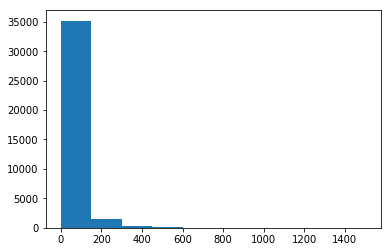

In [7]:
data_loader = AmznDataLoader()

In [8]:
np.count_nonzero(data_loader.X_train)/(data_loader.X_train.shape[0]*data_loader.X_train.shape[1])

0.551273569023569

In [9]:
data_loader.X_train.shape
# data_loader.buildCorpus()

(29700, 40)

In [10]:
weight_matrix = data_loader.weight_matrix
import sys
print(sys.getsizeof(weight_matrix)/(2**20))

# print(weight_matrix[0])
# print(weight_matrix.shape)

20.086395263671875


In [11]:
pickle.dump(weight_matrix,  open('./data/GloveMatrix.npy', 'wb'))

In [12]:
# todo reset parameters for linear layer
class ReviewModel(nn.Module):
    def __init__(self, max_length, batch_size):
        super(ReviewModel, self).__init__()
        weights_matrix = data_loader.weight_matrix
        self.max_length = max_length
        self.batch_size = batch_size
        self.embedding = nn.Embedding.from_pretrained(torch.tensor(weights_matrix), freeze=False)
#        self.embedding = nn.Embedding(weights_matrix.shape[0],weights_matrix.shape[1])
#         self.embedding.weight.data.copy_(torch.from_numpy(weights_matrix))
        self.drop1 = nn.Dropout(p=0.5)
        self.conv1 = nn.Conv1d(in_channels=50, out_channels=200, kernel_size=4, padding=2).double()
        self.conv2 = nn.Conv1d(in_channels=50, out_channels=200, kernel_size=5, padding=2).double()
        self.maxpool = nn.MaxPool1d(kernel_size=2)
        self.drop2 = nn.Dropout(p=0.15)
        
        self.rnn = nn.GRU(input_size=400, hidden_size=100, num_layers=1, batch_first=False)  #
#        self.fc1 =nn.Linear(in_features=1501*100, out_features = 400)
        self.fc1 =nn.Linear(in_features=(max_length//2)*100, out_features = 400)
        self.drop3 = nn.Dropout(p=0.1)
        self.fc2 = nn.Linear(in_features=400, out_features=5)
        
    def forward(self, x):
#         print("input tensor", x.size())
        x = self.embedding(x)
#         print("after embedding", x.size())
        x = self.drop1(x)
#        print(x)
        x = x.view(-1,50,self.max_length)  # input(N,C_in,L) to conv1d
        x1 = F.relu(self.conv1(x))
#         print("x1 shape", x1.size())
        x2 = F.relu(self.conv2(x))
#         print("x2 shape ", x2.size())

        x1 = self.maxpool(x1)
#         print("x1 shape", x1.size())        
        x2 = self.maxpool(x2)
#         print("x2 shape", x2.size())        
        x = torch.cat((x1,x2), 1)
        x = self.drop2(x)
        
        x = x.view((self.max_length//2),-1, 400).float()#### change dimensionality
        
        hidden = Variable(torch.cuda.FloatTensor(1, batch_size, 100).uniform_()) 
        
#        print("before rnn ", x.size(), "hidden size ",hidden.size())

        output, _ = self.rnn(x,hidden)
#         print("AFTER rnn ",output.size())
        
        x = output.contiguous().view(-1, (self.max_length//2)*100)
        x = F.relu(self.fc1(x))
        x = self.drop3(x)
        x = self.fc2(x)
        return x
    
    
#     def create_emb_layer(self, weights_matrix, non_trainable=True):
#         num_embeddings, embedding_dim = weights_matrix.shape
#         emb_layer = nn.Embedding(num_embeddings, embedding_dim)
#         emb_layer.load_state_dict({'weight': weights_matrix})
#         if non_trainable:
#             emb_layer.weight.requires_grad = False

#         return emb_layer, num_embeddings, embedding_dim
    

In [13]:
from skorch.callbacks import EpochScoring, PrintLog, ProgressBar, LRScheduler, EarlyStopping
from sklearn.metrics import accuracy_score

In [14]:
def ds_accuracy(net, ds, y=None):
    # assume ds yields (X, y), e.g. torchvision.datasets.MNIST
    y_true = [y for _, y in ds]
    y_pred = net.predict(ds)
    return sklearn.metrics.accuracy_score(y_true, y_pred)
    

callbacks = [
    ('es1',EpochScoring('accuracy')),
    ('lrs',LRScheduler()),
    ('est',EarlyStopping()) 
]

batch_size = 256
device = torch.device("cuda:0")
model = ReviewModel(data_loader.X_train.shape[1], batch_size).to(device)
net = NeuralNetClassifier(model,## change dimensionality
                          iterator_train__drop_last = True,
                          iterator_valid__drop_last = True, 
                          max_epochs=30, 
                          lr=0.01, 
                          criterion = nn.CrossEntropyLoss, 
                          optimizer=optim.SGD,
                          batch_size = batch_size,
                          callbacks = callbacks,
                          device = torch.device('cuda:0')
                          )


In [15]:
inputs = torch.from_numpy(data_loader.X_train).long().to(device)
labels = torch.tensor(data_loader.y_train.values).long().to(device)
# rest = inputs.size()[0] % batch_size
# print(rest)
# print(inputs.size())
# inputs = inputs[:-rest]
# print(inputs.size()[0]/batch_size)
# print(inputs.shape)
# labels = labels[:-rest]

net.fit(inputs, labels)

RuntimeError: cublas runtime error : the GPU program failed to execute at /opt/conda/conda-bld/pytorch_1549635019666/work/aten/src/THC/THCBlas.cu:258

In [ ]:
net.get_params()


In [ ]:
# m = data_loader.indicesMatrix()
import sklearn
sorted(sklearn.metrics.SCORERS.keys())

In [ ]:
import matplotlib.pyplot as plt
def plot_losses(tr_loss, val_loss):
    plt.plot(tr_loss, label="training")
    plt.plot(val_loss, label="validation")
    plt.legend()
    plt.show()

In [ ]:
#todo plot losses
#todo plot accuracy
#todo confusion matrix
history = net.history
train_losses = history[:, 'train_loss']
valid_losses = history[:, 'valid_loss']

accuracy = history[:, 'accuracy']
plot_losses(train_losses, valid_losses)

In [ ]:
y

In [ ]:
w = torch.tensor(weights_matrix).double()

In [ ]:
w

In [ ]:
Variable(w.double())